Get imports and initialize matplotlib...

In [1]:
from collections import OrderedDict
import numpy as np
import tensorflow as tf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Get metadata from csv file...

In [2]:
ids = []
targets = OrderedDict()
with open('labels.csv') as f:
    header = f.readline()
    for line in f:
        idzone, label = line.split(',')
        sampleid, zone = idzone.split('_')
        zone_number = int(zone[len('Zone'):]) # string looks like "Zone8" so this chops off "Zone"
        
        if sampleid not in targets:
            ids.append(sampleid)
            targets[sampleid] = np.zeros(18)
        targets[sampleid][zone_number] = float(label)

Create our (giant...) matrices for training. Takes up roughly 12 GB of system memory (thankfully mine as 32)

Set n to a value to reduce this size for testing

In [3]:
X_train = [] # training data
y_train = [] # training one hot labels
l_train = [] # training labels

i = 0
n = 2 # len(ids)
for sid in ids:
    path = 'data/{}.aps.npz'.format(sid)

    npzfile = np.load(path)
    data = npzfile['arr_0']
    X_train.append(data)
    y_train.append(targets[sid])
    l_train.append(np.argmax(targets[sid]))
    
    i += 1
    print (i, "of", n, end="\r")
    if i >= n:
        break

X_train = np.moveaxis(X_train, 3, 0)
print (np.shape(X_train))

(16, 2, 512, 660)


For some reason the perspective is the last axis in the matrix, move it to be the second matrix so it's more logical (doesn't actually make a difference from a training perspective)

X_train should now be in the form [sampleIndex, perspective, x, y]

Also, moveaxis somehow does this operation while using zero extra memory, no idea how but clearly whoever made it had a better professor for algorithms than Gelfond

Print matrix...

In [4]:
print (X_train[1][0]) # first sample from the 4th perspective
print (y_train[0])
print (l_train[0])

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
14


Show Image...

TypeError: Invalid dimensions for image data

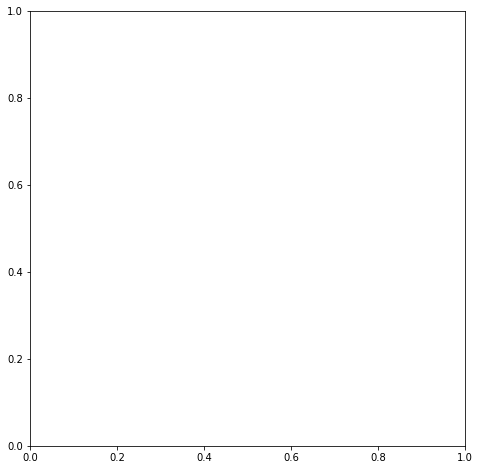

In [13]:
from matplotlib.pyplot import imshow 
figsize(16,8)
im = imshow(np.flipud(X_train[15,4:,:].T), cmap = 'viridis') # 1st sample, 4th perspective

make .train() ...

In [6]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    """ Adopted from https://www.tensorflow.org/tutorials/layers """
    
    # images in shape: (perspectives, samples, width, height)
    
#     (n, w, h) = np.shape(features["x"])
    w = 512
    h = 660
    
    outputs = 18
    
    input_layer = tf.reshape(features["x"], [-1, w, h, 1])
    input_layer = tf.cast(input_layer, tf.float16)
    
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=2,
      kernel_size=[12, 12],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[8, 8], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=4,
      kernel_size=[12, 12],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[8, 8], strides=2)

    # Dense Layer
    wid = pool2.get_shape()[1].value
    hei = pool2.get_shape()[2].value
    
    neurons = wid * hei * 4
    
    pool2_flat = tf.reshape(pool2, [-1, neurons])
    dense = tf.layers.dense(inputs=pool2_flat, units=neurons, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=outputs)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=outputs)
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

run .train() ...

In [7]:

configconfig = tf.ConfigProto()
configconfig.log_device_placement = True
configconfig.gpu_options.allow_growth = True

config = tf.contrib.learn.RunConfig(session_config = configconfig)


# Create the Estimator
tsa_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="tmp/tsa_cnn_model",config=config)


# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":X_train[0].reshape(len(X_train[0]), len(X_train[0][0]) * len(X_train[0][0][0]))},
    y=np.asarray(l_train),
    batch_size=1,
    num_epochs=None,
    shuffle=True)
tsa_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Using config: {'_model_dir': 'tmp/tsa_cnn_model', '_environment': 'local', '_master': '', '_is_chief': True, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 0, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
log_device_placement: true
, '_evaluation_master': '', '_tf_random_seed': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002355D2D2588>, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_task_type': None}
INFO:tensorflow:Create CheckpointSaverHook.


ResourceExhaustedError: OOM when allocating tensor with shape[78720,78720]
	 [[Node: dense/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@dense/kernel"], dtype=DT_HALF, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/gpu:0"](dense/kernel/Initializer/random_uniform/shape)]]

Caused by op 'dense/kernel/Initializer/random_uniform/RandomUniform', defined at:
  File "d:\misc\anaconda\envs\tf2\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\misc\anaconda\envs\tf2\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-bb2c9c9c71e1>", line 29, in <module>
    hooks=[logging_hook])
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\estimator\estimator.py", line 241, in train
    loss = self._train_model(input_fn=input_fn, hooks=hooks)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\estimator\estimator.py", line 630, in _train_model
    model_fn_lib.ModeKeys.TRAIN)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\estimator\estimator.py", line 615, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-6-e8e1aad04c39>", line 44, in cnn_model_fn
    dense = tf.layers.dense(inputs=pool2_flat, units=neurons, activation=tf.nn.relu)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\layers\core.py", line 215, in dense
    return layer.apply(inputs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\layers\base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\layers\base.py", line 443, in __call__
    self.build(input_shapes[0])
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\layers\core.py", line 118, in build
    trainable=True)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\layers\base.py", line 383, in add_variable
    trainable=trainable and self.trainable)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\init_ops.py", line 441, in __call__
    dtype, seed=self.seed)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 247, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "d:\misc\anaconda\envs\tf2\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[78720,78720]
	 [[Node: dense/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@dense/kernel"], dtype=DT_HALF, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/gpu:0"](dense/kernel/Initializer/random_uniform/shape)]]
